## Lunar Lander with PPO

The goal of this notebook is to demonstrate training Stable Baselines's algorithms (PPO)
with Gymnasium environments (Lunar Lander).

The previous notebook was simple and all self-contained.

The current notebook relies on reusable functions which are shared in `rlcourse` package and introduces various advanced techniques:
- Designing notebook such that it can use the custom library `rlcourse` when run locally and when run in environments such as Google Colab, Kaggle and others.
- Notifications of long running job completion with Telegram messages.
- Using multi-processing to speedup model training.
- Simple code for hyperparameter search: in this case it is interesting to find a set of hyperparameters that lead to quicker solution.

### Setup

First step: find course helpers library and update `sys.path` to find it.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, subprocess

repo_url = "https://github.com/anton-dergunov/hugging-face-deep-rl.git"
target_dir = "hugging-face-deep-rl"
local_src = os.path.abspath("../src")

if os.path.isdir(local_src):
    repo_root = os.path.abspath("..")
    print("✅ Using local source for course helpers")
else:
    if not os.path.exists(target_dir):
        subprocess.run(["git", "clone", repo_url, target_dir], check=True)
    repo_root = os.path.abspath(target_dir)
    print("✅ Cloned repo with course helpers")

src_path = os.path.join(repo_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"🔧 sys.path updated with: {src_path}")

✅ Using local source for course helpers
🔧 sys.path updated with: /Users/anton/Dropbox/src/hugging-face-deep-rl/src


In [3]:
from rlcourse.system_setup import setup_env
setup_env()

🔧 Bootstrapping environment...
✅ swig already installed


📦 Packages installed
🔇 Warnings filtered
✅ Environment ready


In [ ]:
import os

from IPython.display import Video
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter

from rlcourse.hf_utils import HuggingFaceModelHub
import rlcourse.gymnasium_utils as utils
from rlcourse.notifier import Notify

In [5]:
ENV_ID = "LunarLander-v3"
MODEL_NAME = "LunarLander_PPO"
REPO_ID = f"AntonDergunov/{MODEL_NAME}"

LEARN_STEPS = 1_000_000

In [ ]:
BEST_MODEL_PATH = f"models/{MODEL_NAME}.zip"
VIDEO_PATH = f"videos/{MODEL_NAME}.mp4"

os.makedirs(os.path.dirname(BEST_MODEL_PATH), exist_ok=True)
os.makedirs(os.path.dirname(VIDEO_PATH), exist_ok=True)

### Environment

[Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) is a classic rocket trajectory optimization problem.

Observation Space:
1. x coordinate (horizontal position)
2. y coordinate (vertical position)
3. horizontal velocity
4. vertical velocity
5. lander angle
6. angular velocity
7. is left leg touching ground? (boolean)
8. is right leg touching ground? (boolean)

Action Space - 4 discrete actions:
- 0 = do nothing
- 1 = fire left orientation engine
- 2 = fire main engine
- 3 = fire right orientation engine

The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

Episode finishes if the lander:
- crashes (gets in contact with the moon)
- gets outside of the viewpoint
- is not awake (does not move and does not collide)

"At each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points."

In [7]:
env = gym.make(ENV_ID, render_mode="rgb_array")

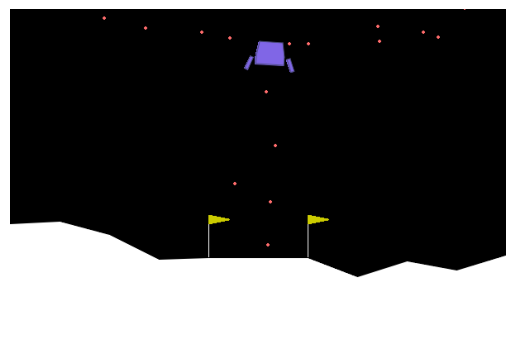

In [8]:
utils.show_environment(env)

In [9]:
utils.describe_environment(env)

Observation Space:
  Box(shape=(8,), dtype=float32, low=-10.0, high=10.0)
  Example observation: [ 0.18891713  2.4967089  -0.48614734 -4.5445766   1.8648353  -6.5178633
  0.11990633  0.65755063]

Action Space:
  Discrete(n=4)
  Example action: 1

Max episode steps: 1000


### Train PPO Model in a Single Process

In [25]:
LOGS_PATH_SINGLE_PROC = f"logs/{MODEL_NAME}_single_proc"
os.makedirs(LOGS_PATH_SINGLE_PROC, exist_ok=True)

vec_env = make_vec_env(ENV_ID, n_envs=4, monitor_dir=LOGS_PATH_SINGLE_PROC)

# Using PPO model with default hyperparameters
model_single_proc = PPO(
    policy = 'MlpPolicy',
    env = vec_env)

with Notify(f"{MODEL_NAME}: Training in a Single Process"):
    model_single_proc.learn(total_timesteps=LEARN_STEPS, progress_bar=True)

Output()

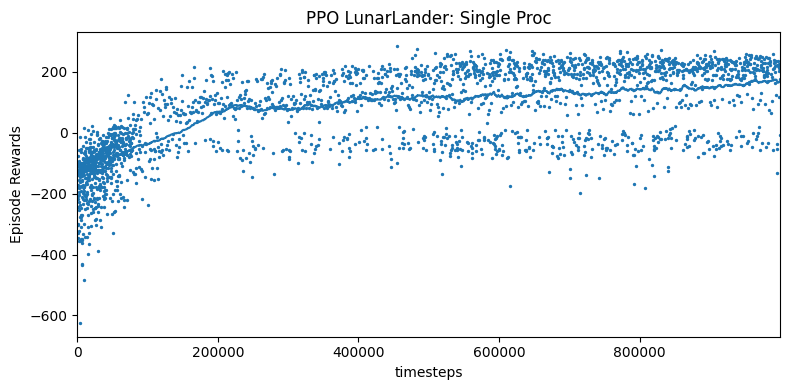

In [26]:
# Plot results using Stable-Baselines3 helper
plot_results([LOGS_PATH_SINGLE_PROC], LEARN_STEPS, results_plotter.X_TIMESTEPS, "PPO LunarLander: Single Proc", figsize=(8,4))
plt.show()

In [27]:
print(utils.evaluate_model(model_single_proc, ENV_ID))

{'mean_reward': np.float64(186.53512969999997), 'std_reward': np.float64(63.778052057461394), 'n_eval_episodes': 10}


### Train PPO Model with Multiprocessing

https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#multiprocessing-unleashing-the-power-of-vectorized-environments

In [28]:
def make_subproc_env(env_id, n_proc, seed, log_dir=None):
    """
    Creates vectorized environment with multiprocessing.

    :param env_id: the environment ID
    :param n_proc: number of subprocess
    :param seed: the initial seed for RNG
    :param log_dir: directory to save Monitor logs
    """
    def make_env(env_id: str, rank: int, seed: int = 0, log_dir: str = None):
        def _init():
            # Silence warnings inside the subprocess
            import warnings
            warnings.filterwarnings("ignore", category=DeprecationWarning, module="pygame")
            warnings.filterwarnings("ignore", category=UserWarning, module="pygame")
            warnings.filterwarnings("ignore", category=DeprecationWarning, module="pkg_resources")

            env = gym.make(env_id)
            env.reset(seed=seed + rank)
            if log_dir is not None:
                env = Monitor(env, filename=os.path.join(log_dir, f"proc_{rank}"))
            return env

        set_random_seed(seed)
        return _init

    return SubprocVecEnv([make_env(env_id, i, seed=seed, log_dir=log_dir) for i in range(n_proc)])

In [29]:
LOGS_PATH_MULTI_PROC = f"logs/{MODEL_NAME}_multi_proc"
os.makedirs(LOGS_PATH_MULTI_PROC, exist_ok=True)

# Use SubprocVecEnv for multiprocessing
num_cpu = os.cpu_count()
print(f"Using {num_cpu} subprocesses.")

subproc_vec_env = make_subproc_env(ENV_ID, num_cpu, seed=0, log_dir=LOGS_PATH_MULTI_PROC)

Using 8 subprocesses.


In [19]:
# Using PPO model with default hyperparameters
model_multi_proc = PPO(
    policy = 'MlpPolicy',
    env = subproc_vec_env)

with Notify(f"{MODEL_NAME}: Training with Multiprocessing"):
    model_multi_proc.learn(total_timesteps=LEARN_STEPS, progress_bar=True)

Output()

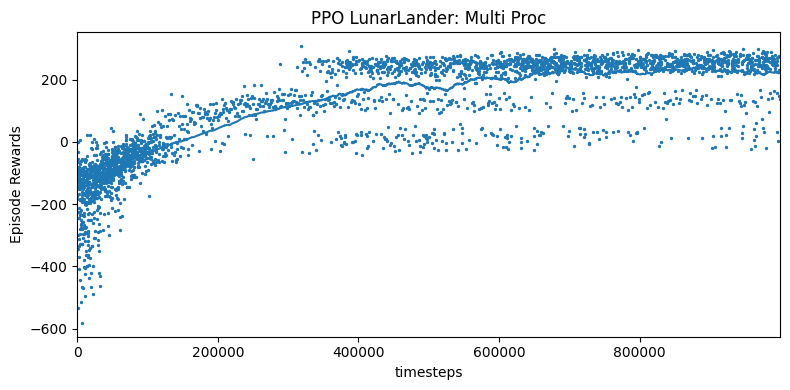

In [23]:
# Plot results using Stable-Baselines3 helper
plot_results([LOGS_PATH_MULTI_PROC], LEARN_STEPS, results_plotter.X_TIMESTEPS, "PPO LunarLander: Multi Proc", figsize=(8,4))
plt.show()

In [24]:
print(utils.evaluate_model(model_multi_proc, ENV_ID))

{'mean_reward': np.float64(246.90662269999999), 'std_reward': np.float64(13.05390113303241), 'n_eval_episodes': 10}


### Find Optimal Hyperparameters for PPO Model

The goal is to find hyperparameters for training PPO faster.

In [ ]:
# required imports
import os, json, random
import numpy as np
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.logger import configure
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold, CallbackList
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed


def run_experiment(
    env_id,
    config,
    exp_name,
    seed=0,
    total_timesteps=1_000_000,
    base_dir="experiments"
):
    """
    Runs one experiment.
    - config: dict with keys like n_envs, n_steps, batch_size, n_epochs, learning_rate, gamma, gae_lambda, ent_coef, eval_freq, n_eval_episodes
    - exp_name: string used to organize logs
    - seed: RNG seed
    """
    run_dir = os.path.join(base_dir, exp_name, f"seed_{seed}")
    os.makedirs(run_dir, exist_ok=True)
    train_logdir = os.path.join(run_dir, "train")
    eval_logdir = os.path.join(run_dir, "eval")
    best_dir = os.path.join(run_dir, "best")
    os.makedirs(train_logdir, exist_ok=True)
    os.makedirs(eval_logdir, exist_ok=True)
    os.makedirs(best_dir, exist_ok=True)

    # 1) create envs
    vec_env = make_subproc_env(env_id, n_envs=config["n_envs"], seed=seed, log_dir=train_logdir)
    eval_env = make_subproc_env(env_id, n_envs=1, seed=seed + 1000, log_dir=eval_logdir)

    # 2) build model (set logger so SB3 writes CSV/TensorBoard into run_dir)
    new_logger = configure(run_dir, ["csv", "tensorboard"])
    model = PPO(
        policy="MlpPolicy",
        env=vec_env,
        n_steps=config["n_steps"],
        batch_size=config["batch_size"],
        n_epochs=config["n_epochs"],
        learning_rate=config["learning_rate"],
        gamma=config["gamma"],
        gae_lambda=config["gae_lambda"],
        ent_coef=config["ent_coef"],
        verbose=0,
        tensorboard_log=os.path.join(run_dir, "tensorboard"),
    )
    model.set_logger(new_logger)

    # 3) callbacks: eval + stop on threshold
    stop_cb = StopTrainingOnRewardThreshold(reward_threshold=config.get("reward_threshold", 200), verbose=1)
    eval_cb = EvalCallback(
        eval_env,
        best_model_save_path=best_dir,
        log_path=eval_logdir,
        eval_freq=config.get("eval_freq", 10_000),
        n_eval_episodes=config.get("n_eval_episodes", 5),
        deterministic=True,
        callback_on_new_best=stop_cb,
    )

    # 4) save config
    with open(os.path.join(run_dir, "config.json"), "w") as f:
        json.dump(config, f, indent=2)

    # 5) train (safely)
    try:
        model.learn(total_timesteps=total_timesteps, callback=eval_cb, progress_bar=True)
    finally:
        # always save and close envs (ensures resources released)
        model.save(os.path.join(run_dir, "final_model.zip"))
        try:
            vec_env.close()
        except Exception:
            pass
        try:
            eval_env.close()
        except Exception:
            pass

    return run_dir

In [ ]:
# Search space (TODO describe it!)
search_space = {
    "n_envs": [4],                     # try 4 or 8 if you have CPU
    "n_steps": [512, 1024, 2048],
    "batch_size": [64],
    "n_epochs": [3, 4],
    "learning_rate": [1e-4, 3e-4, 1e-3],
    "gamma": [0.99, 0.999],
    "gae_lambda": [0.95, 0.98],
    "ent_coef": [0.0, 0.01],
    "eval_freq": [5000, 10000],
    "n_eval_episodes": [5],
    "reward_threshold": [220],
}

In [ ]:
def sample_config(space):
    return {k: random.choice(v) for k, v in space.items()}

# run multiple configs sequentially (one machine)
N = 6
for i in range(N):
    cfg = sample_config(search_space)
    exp_name = f"hp_run_{i}"
    print("Running", exp_name, cfg)
    run_dir = run_experiment(ENV_ID, cfg, exp_name, seed=100+i, total_timesteps=200_000)
    print("Finished", run_dir)

In [ ]:
import glob
import numpy as np
import pandas as pd
from pathlib import Path

def analyze_experiments(base_dir="experiments", threshold=200):
    rows = []
    for exp_dir in Path(base_dir).glob("*/"):
        for seed_dir in exp_dir.glob("seed_*"):
            run_path = str(seed_dir)
            eval_npz = os.path.join(run_path, "eval", "evaluations.npz")
            cfg_file = os.path.join(run_path, "config.json")
            if not os.path.exists(eval_npz):
                continue
            data = np.load(eval_npz, allow_pickle=True)
            timesteps = data["timesteps"]
            results = data["results"]
            # results can be shape (n_eval,) or (n_eval, n_episodes) or list-like
            if results.ndim == 2:
                mean_rewards = results.mean(axis=1)
            else:
                mean_rewards = np.array(results).astype(float)

            # time to solve
            solved_idx = np.where(mean_rewards >= threshold)[0]
            time_to_solve = int(timesteps[solved_idx[0]]) if len(solved_idx) > 0 else np.nan
            final_reward = float(mean_rewards[-1])
            # approximate AUC normalized by last timestep
            try:
                auc = float(np.trapz(mean_rewards, x=timesteps) / (timesteps[-1] if timesteps[-1] > 0 else 1.0))
            except Exception:
                auc = np.nan

            # load config
            try:
                with open(cfg_file) as f:
                    cfg = json.load(f)
            except Exception:
                cfg = {}

            rows.append({
                "run": exp_dir.name,
                "seed": seed_dir.name,
                "run_path": run_path,
                "time_to_solve": time_to_solve,
                "final_reward": final_reward,
                "auc": auc,
                "timesteps_last": int(timesteps[-1]),
                "config": cfg,
            })

    df = pd.DataFrame(rows)
    # expand config columns for convenience (careful with missing keys)
    cfg_df = pd.json_normalize(df["config"])
    df2 = pd.concat([df.drop(columns=["config"]), cfg_df], axis=1)
    return df2

# usage
df_results = analyze_experiments("experiments", threshold=200)
df_results.sort_values(["time_to_solve", "final_reward"], ascending=[True, False]).head(10)


### Evaluate

In [ ]:
# TODO: Load the saved best model
best_model = PPO.load(BEST_MODEL_PATH, device="cpu")

In [ ]:
metrics = utils.evaluate_model(best_model, ENV_ID)
print(metrics)

{'mean_reward': np.float64(259.9094436), 'std_reward': np.float64(18.95278879636738), 'n_eval_episodes': 10}


In [ ]:
utils.record_agent_video(best_model, ENV_ID, video_path=VIDEO_PATH, steps=1000)

Saved video to videos/LunarLander_PPO.mp4


In [19]:
Video(VIDEO_PATH, embed=True)

### Hugging Face

In [9]:
hub = HuggingFaceModelHub()
hub.login_if_needed(interactive=True)

✅ Hugging Face credentials already available.


In [ ]:
usage = f"""
```python
import gymnasium as gym
from stable_baselines3 import PPO
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(repo_id="{REPO_ID}", filename="model.zip")
model = PPO.load(model_path, device="cpu")

env = gym.make("{ENV_ID}")
obs, info = env.reset()

for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        obs, info = env.reset()
```
"""

hub.upload_model_file(
    repo_id=REPO_ID,
    file=BEST_MODEL_PATH,
    filename="model.zip",
    model_name=MODEL_NAME,
    library="Stable-Baselines3",
    algo="PPO",
    env_id=ENV_ID,
    metrics=metrics,
    video_file=VIDEO_PATH,
    readme_extra=usage,
)

✅ Hugging Face credentials already available.
Uploading model.zip to AntonDergunov/LunarLander_PPO ... | size=146.68 KB | sha256=b1f5b6a89b5a3c691975ff6073b556c4c033060c8df7c5cff001386473e184f4


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.



✅ Upload complete! View the model at:
https://huggingface.co/AntonDergunov/LunarLander_PPO


In [12]:
hub_model_file = hub.download_model_file(repo_id=REPO_ID, filename="model.zip")
model = PPO.load(hub_model_file, device="cpu")

env = gym.make(ENV_ID)
obs, info = env.reset()

for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        obs, info = env.reset()

print("✅ Model loaded from Hugging Face and tested successfully!")

Downloaded /Users/anton/.cache/huggingface/hub/models--AntonDergunov--LunarLander_PPO/snapshots/f0943663a907fc5e8b2be11fbc6eb9ffd96bf1b7/model.zip | size=146.68 KB | sha256=b1f5b6a89b5a3c691975ff6073b556c4c033060c8df7c5cff001386473e184f4
✅ Model loaded from Hugging Face and tested successfully!
